<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>Projet Fil Rouge CO2</h1></center>
<center><h2>Modélisation - classification
    </h2></center>
<hr style="border-width:2px;border-color:#75DFC1">

Anthony et Isabelle - mentor Maxime

Le but de ce projet est d'identifier les caractéristiques techniques des véhicules qui jouent un rôle dans l'émission de CO2 à partir d'une base de données produite par l'Agence européenne de l'environnement qui contient la liste des voitures particulières enregistrés en France pour l'année 2019.

Ce document centralise les étapes de modélisation pour les méthodes de classification. Tous les modèles ainsi que leurs étapes d'optimisation ont été effectuées en double, afin de représenter les deux normes NEDC et WLTP.

> La structure du notebook est la suivante : 
>> I - [Préparation des données](#preparation)
>>    - Suppression de variables non utiles pour la modélisation
>>    - Dichotomisation des variables catégorielles
>>
>> II - [1er modèle : Régression logistique](#lr)
>>
>>
>> III - [2ème modèle : Méthode des K plus proches voisins](#knn)
>>    - Simple
>>    - Optimisé
>>    - Importance des métriques
>>
>> IV - [3ème modèle : Arbre de décisions](#dt)
>>    - Simple
>>    - Optimisation avec GridSearchCV
>>    - Importance des variables
>>    - Affichage des premiers noeuds
>>
>> V - [4ème modèle : XGBoost](#xgboost)
>>    - Simple
>>    - Optimisation avec la librairie Hyperopt
>>    - Affichage de l'importance avec Shap
>>

## Import des librairies, lecture des données

In [482]:
# import des packages nécessaires à la modélisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score
import shap
import hyperopt
from hyperopt import fmin, tpe, space_eval, tpe, Trials, STATUS_OK

In [483]:
# lecture des données après pre-processing
cars = pd.read_csv('cars_FR2019_clean.csv', dtype={'Cn': 'str', 'IT': 'uint8'},index_col=0)
display(cars.shape)
cars.head()

(13571, 24)

,Mp,Mh,T,Va,Ve,Cn,Ct,Cr,r,m,...,At1,At2,Ft,Fm,ec,ep,IT,size,At2supAt1,indicator
0,SUZUKI POOL,SUZUKI MOTOR CORPORATION,AZ,C53S,MT2,SWIFT,M1,M1,1,925,...,1520,1520,petrol,NOVC-HEV,1242.0,66.0,0,3230,0,False
1,FCA-TESLA,FIAT GROUP,312,PXA1A,P0AY,PANDA,M1,M1,1,1075,...,1426,1426,petrol,mono_fuel,1242.0,51.0,0,240,0,False
2,FCA-TESLA,FIAT GROUP,312,PXA1A,P0AZ,PANDA,M1,M1,1,1075,...,1426,1426,petrol,mono_fuel,1242.0,51.0,0,743,0,False
3,FCA-TESLA,FIAT GROUP,312,PXA1A,P0BF,PANDA,M1,M1,1,1055,...,1409,1409,petrol,mono_fuel,1242.0,51.0,0,1984,0,False
4,FCA-TESLA,FIAT GROUP,312,PXA1A,P0BG,PANDA,M1,M1,1,1055,...,1409,1409,petrol,mono_fuel,1242.0,51.0,0,2205,0,False


## <a name="preparation"></a> Préparation des données

### Suppression et dichotomisation de variables

In [484]:
# Suppression des colonnes non pertinentes pour la modélisation
cars = cars.drop(columns = ['Mh', 'T', 'Va', 'Ve', 'Cn', 'Cr', 'r', 'size', 'indicator'])

# Suppression de la variable 'At2' car colinéaire avec 'At1'
cars = cars.drop('At2', axis=1)

# Dichotomisation de la variable 'Ct'
cars['Ct'] = cars['Ct'].replace(['M1', 'M1G'], [0, 1]).astype('uint8')

# Dichotomisation des autres variables ('Ft' et 'Fm')
cars = pd.get_dummies(cars)

### Discrétisation des variables d'émission de CO2 en quartile

In [485]:
# Discrétisation des variables d'émission de CO2 en quartile
cars['EnedcQuart'] = pd.qcut(cars['Enedc'], q=4, labels=[1,2,3,4])
cars['EwltpQuart'] = pd.qcut(cars['Ewltp'], q=4, labels=[1,2,3,4])
# Suppression des anciennes variables
cars = cars.drop(['Enedc', 'Ewltp'], axis=1)

In [487]:
cars.head()

,Ct,m,Mt,W,At1,ec,ep,IT,At2supAt1,Mp_BMW GROUP,...,Mp_SUZUKI POOL,Mp_TOYOTA-MAZDA,Mp_VW GROUP,Ft_diesel,Ft_petrol,Fm_NOVC-HEV,Fm_OVC-HEV,Fm_mono_fuel,EnedcQuart,EwltpQuart
0,0,925,1051.0,2450.0,1520,1242.0,66.0,0,0,0,...,1,0,0,0,1,1,0,0,1,1
1,0,1075,1151.0,2300.0,1426,1242.0,51.0,0,0,0,...,0,0,0,0,1,0,0,1,2,1
2,0,1075,1162.0,2300.0,1426,1242.0,51.0,0,0,0,...,0,0,0,0,1,0,0,1,2,2
3,0,1055,1142.0,2300.0,1409,1242.0,51.0,0,0,0,...,0,0,0,0,1,0,0,1,1,2
4,0,1055,1145.0,2300.0,1409,1242.0,51.0,0,0,0,...,0,0,0,0,1,0,0,1,1,2


In [486]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13571 entries, 0 to 13570
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Ct               13571 non-null  uint8   
 1   m                13571 non-null  int64   
 2   Mt               13571 non-null  float64 
 3   W                13571 non-null  float64 
 4   At1              13571 non-null  int64   
 5   ec               13571 non-null  float64 
 6   ep               13571 non-null  float64 
 7   IT               13571 non-null  uint8   
 8   At2supAt1        13571 non-null  int64   
 9   Mp_BMW GROUP     13571 non-null  uint8   
 10  Mp_DAIMLER AG    13571 non-null  uint8   
 11  Mp_FCA-TESLA     13571 non-null  uint8   
 12  Mp_FORD-WERKE    13571 non-null  uint8   
 13  Mp_HYUNDAI       13571 non-null  uint8   
 14  Mp_JLR           13571 non-null  uint8   
 15  Mp_KIA           13571 non-null  uint8   
 16  Mp_OTHER         13571 non-null  uint8  

### Séparation du dataset en jeux de données pour les deux normes : NEDC et WLTP

In [488]:
# Séparation des features et targets
features_nedc = cars.drop(['Mt', 'EnedcQuart', 'EwltpQuart'], axis=1)
target_nedc = cars.EnedcQuart

features_wltp = cars.drop(['m', 'EnedcQuart', 'EwltpQuart'], axis=1)
target_wltp = cars.EwltpQuart

# Séparation des données en jeu d'entrainement et de test pour la norme NEDC
X_train_nedc, X_test_nedc, y_train_nedc, y_test_nedc = train_test_split(features_nedc, target_nedc, test_size=.2)

# Séparation des données en jeu d'entrainement et de test pour la norme WLTP
X_train_wltp, X_test_wltp, y_train_wltp, y_test_wltp = train_test_split(features_wltp, target_wltp, test_size=.2)

# Normalisation des donnéees norme NEDC
scaler = StandardScaler()
X_train_nedc_scaled = scaler.fit_transform(X_train_nedc)
X_test_nedc_scaled = scaler.transform(X_test_nedc)

# Normalisation des donnéees norme WLTP
scaler = StandardScaler()
X_train_wltp_scaled = scaler.fit_transform(X_train_wltp)
X_test_wltp_scaled = scaler.transform(X_test_wltp)

## <a name="lr"></a>  1er modèle : Régression logistique

### Norme NEDC

#### Entrainement d'un modèle par défaut et affichage de ses performances

In [489]:
# Entrainement d'un premier modèle de régression logistique (NEDC)
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_nedc_scaled, y_train_nedc)
# Affichage des performances du modèle
y_pred_train = lr.predict(X_train_nedc_scaled)
y_pred_test = lr.predict(X_test_nedc_scaled)
print(classification_report(y_train_nedc, y_pred_train))
print(classification_report(y_test_nedc, y_pred_test))
pd.crosstab(y_test_nedc, y_pred_test, colnames=['Predictions'])

              precision    recall  f1-score   support

           1       0.78      0.80      0.79      2838
           2       0.62      0.64      0.63      2696
           3       0.68      0.68      0.68      2602
           4       0.89      0.86      0.87      2720

    accuracy                           0.74     10856
   macro avg       0.74      0.74      0.74     10856
weighted avg       0.74      0.74      0.74     10856

              precision    recall  f1-score   support

           1       0.78      0.80      0.79       720
           2       0.60      0.62      0.61       652
           3       0.70      0.69      0.69       709
           4       0.89      0.85      0.87       634

    accuracy                           0.74      2715
   macro avg       0.74      0.74      0.74      2715
weighted avg       0.74      0.74      0.74      2715



Predictions,1,2,3,4
EnedcQuart,,,,
1,575,130,15,0
2,133,405,114,0
3,23,133,487,66
4,4,10,79,541


### Norme WLTP

#### Entrainement d'un modèle par défaut et affichage de ses performances

In [522]:
# Entrainement d'un premier modèle de régression logistique (WLTP)
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_wltp_scaled, y_train_wltp)
# Affichage des performances du modèle
y_pred_train = lr.predict(X_train_wltp_scaled)
y_pred_test = lr.predict(X_test_wltp_scaled)
print(classification_report(y_train_wltp, y_pred_train))
print(classification_report(y_test_wltp, y_pred_test))
pd.crosstab(y_test_wltp, y_pred_test, colnames=['Predictions'])

              precision    recall  f1-score   support

           1       0.81      0.82      0.81      2858
           2       0.62      0.63      0.63      2623
           3       0.71      0.69      0.70      2764
           4       0.91      0.89      0.90      2611

    accuracy                           0.76     10856
   macro avg       0.76      0.76      0.76     10856
weighted avg       0.76      0.76      0.76     10856

              precision    recall  f1-score   support

           1       0.79      0.82      0.80       645
           2       0.65      0.65      0.65       685
           3       0.72      0.71      0.72       700
           4       0.92      0.91      0.91       685

    accuracy                           0.77      2715
   macro avg       0.77      0.77      0.77      2715
weighted avg       0.77      0.77      0.77      2715



Predictions,1,2,3,4
EwltpQuart,,,,
1,527,103,15,0
2,124,445,116,0
3,12,136,497,55
4,3,2,60,620


## <a name="knn"></a>  2ème modèle : Méthode des K plus proches voisins

### Norme NEDC

#### Entrainement d'un modèle par défaut et affichage de ses performances

In [541]:
# Entrainement d'un premier modèle KNN (NEDC)
knn = KNeighborsClassifier()
knn.fit(X_train_nedc_scaled, y_train_nedc)

# Affichage des performances du modèle
y_pred_train = knn.predict(X_train_nedc_scaled)
y_pred_test = knn.predict(X_test_nedc_scaled)
print(classification_report(y_train_nedc, y_pred_train))
print(classification_report(y_test_nedc, y_pred_test))
pd.crosstab(y_test_nedc, y_pred_test, colnames=['Predictions'])

              precision    recall  f1-score   support

           1       0.91      0.93      0.92      2838
           2       0.86      0.86      0.86      2696
           3       0.88      0.88      0.88      2602
           4       0.96      0.93      0.94      2720

    accuracy                           0.90     10856
   macro avg       0.90      0.90      0.90     10856
weighted avg       0.90      0.90      0.90     10856

              precision    recall  f1-score   support

           1       0.88      0.91      0.89       720
           2       0.77      0.78      0.78       652
           3       0.84      0.84      0.84       709
           4       0.95      0.90      0.93       634

    accuracy                           0.86      2715
   macro avg       0.86      0.86      0.86      2715
weighted avg       0.86      0.86      0.86      2715



Predictions,1,2,3,4
EnedcQuart,,,,
1,654,65,1,0
2,84,510,58,0
3,5,82,595,27
4,1,6,54,573


#### Optimisation du modèle : variation du nombre de voisins et test de 3 métriques de distance différentes

In [542]:
score_minko = []
score_man = []
score_cheb = []

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'minkowski')
    knn.fit(X_train_nedc_scaled, y_train_nedc)
    score_minko.append(knn.score(X_test_nedc_scaled, y_test_nedc))

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'manhattan')
    knn.fit(X_train_nedc_scaled, y_train_nedc)
    score_man.append(knn.score(X_test_nedc_scaled, y_test_nedc))
    
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'chebyshev')
    knn.fit(X_train_nedc_scaled, y_train_nedc)
    score_cheb.append(knn.score(X_test_nedc_scaled, y_test_nedc))
    
import warnings
warnings.filterwarnings('ignore')

#### Affichage des scores en fonction de la métrique de distance et du nombre de voisins

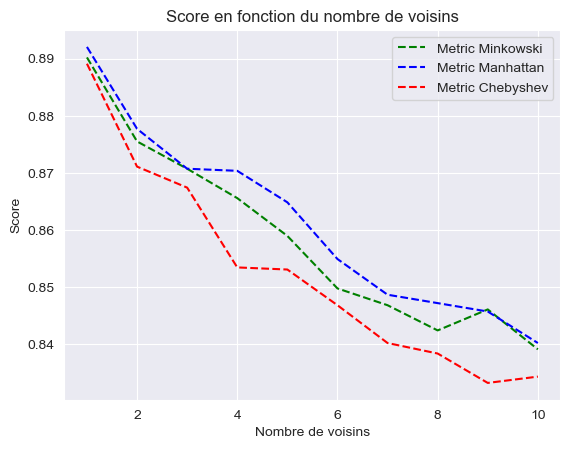

In [543]:
sns.set_style('darkgrid')
plt.plot(range(1, 11), score_minko, 'g--', label = 'Metric Minkowski')
plt.plot(range(1, 11), score_man, 'b--', label = 'Metric Manhattan')
plt.plot(range(1, 11), score_cheb, 'r--', label = 'Metric Chebyshev')
plt.xlabel('Nombre de voisins')
plt.ylabel('Score')
plt.title('Score en fonction du nombre de voisins')
plt.legend();

#### Entrainement du modèle optimisé et affichage de ses performances

In [556]:
# Entrainement d'un second modèle KNN (NEDC)
knn = KNeighborsClassifier(n_neighbors=2, metric='manhattan')
knn.fit(X_train_nedc_scaled, y_train_nedc)
# Affichage des performances du modèle
y_pred_train = knn.predict(X_train_nedc_scaled)
y_pred_test = knn.predict(X_test_nedc_scaled)
print(classification_report(y_train_nedc, y_pred_train))
print(classification_report(y_test_nedc, y_pred_test))
pd.crosstab(y_test_nedc, y_pred_test, colnames=['Predictions'])

              precision    recall  f1-score   support

           1       0.89      0.98      0.93      2838
           2       0.88      0.87      0.87      2696
           3       0.91      0.88      0.90      2602
           4       0.98      0.92      0.95      2720

    accuracy                           0.92     10856
   macro avg       0.92      0.91      0.91     10856
weighted avg       0.92      0.92      0.92     10856

              precision    recall  f1-score   support

           1       0.87      0.95      0.91       720
           2       0.80      0.83      0.81       652
           3       0.88      0.83      0.86       709
           4       0.97      0.90      0.93       634

    accuracy                           0.88      2715
   macro avg       0.88      0.88      0.88      2715
weighted avg       0.88      0.88      0.88      2715



Predictions,1,2,3,4
EnedcQuart,,,,
1,685,35,0,0
2,96,538,18,0
3,3,99,591,16
4,0,2,63,569


### Norme WLTP

#### Entrainement d'un modèle par défaut et affichage de ses performances

In [546]:
# Entrainement d'un premier modèle KNN (WLTP)
knn = KNeighborsClassifier()
knn.fit(X_train_wltp_scaled, y_train_wltp)

# Affichage des performances du modèle
y_pred_train = knn.predict(X_train_wltp_scaled)
y_pred_test = knn.predict(X_test_wltp_scaled)
print(classification_report(y_train_wltp, y_pred_train))
print(classification_report(y_test_wltp, y_pred_test))
pd.crosstab(y_test_wltp, y_pred_test, colnames=['Predictions'])

              precision    recall  f1-score   support

           1       0.91      0.93      0.92      2858
           2       0.83      0.84      0.83      2623
           3       0.88      0.87      0.87      2764
           4       0.96      0.95      0.95      2611

    accuracy                           0.90     10856
   macro avg       0.90      0.89      0.89     10856
weighted avg       0.90      0.90      0.90     10856

              precision    recall  f1-score   support

           1       0.84      0.90      0.87       645
           2       0.76      0.76      0.76       685
           3       0.84      0.80      0.82       700
           4       0.94      0.93      0.93       685

    accuracy                           0.84      2715
   macro avg       0.84      0.85      0.85      2715
weighted avg       0.84      0.84      0.84      2715



Predictions,1,2,3,4
EwltpQuart,,,,
1,579,65,1,0
2,99,519,67,0
3,8,91,557,44
4,1,4,41,639


#### Optimisation du modèle : variation du nombre de voisins et test de 3 métriques de distance différentes

In [547]:
score_minko = []
score_man = []
score_cheb = []

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'minkowski')
    knn.fit(X_train_wltp_scaled, y_train_wltp)
    score_minko.append(knn.score(X_test_wltp_scaled, y_test_wltp))

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'manhattan')
    knn.fit(X_train_wltp_scaled, y_train_wltp)
    score_man.append(knn.score(X_test_wltp_scaled, y_test_wltp))
    
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'chebyshev')
    knn.fit(X_train_wltp_scaled, y_train_wltp)
    score_cheb.append(knn.score(X_test_wltp_scaled, y_test_wltp))
    
warnings.filterwarnings('ignore')

#### Affichage des scores en fonction de la métrique de distance et du nombre de voisins

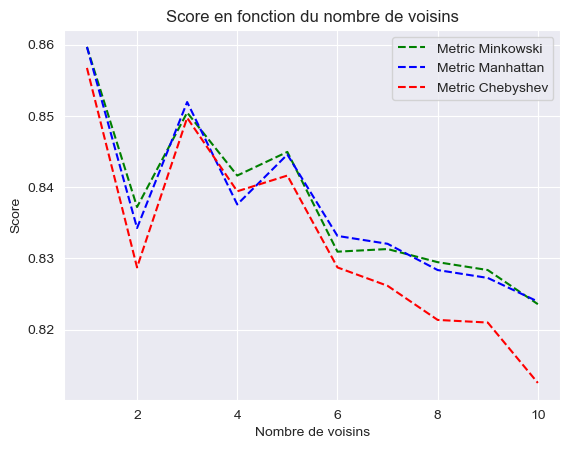

In [548]:
sns.set_style('darkgrid')
plt.plot(range(1, 11), score_minko, 'g--', label = 'Metric Minkowski')
plt.plot(range(1, 11), score_man, 'b--', label = 'Metric Manhattan')
plt.plot(range(1, 11), score_cheb, 'r--', label = 'Metric Chebyshev')
plt.xlabel('Nombre de voisins')
plt.ylabel('Score')
plt.title('Score en fonction du nombre de voisins')
plt.legend();

#### Entrainement du modèle optimisé et affichage de ses performances

In [555]:
# Entrainement d'un second modèle KNN (WLTP)
knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
knn.fit(X_train_wltp_scaled, y_train_wltp)
# Affichage des performances du modèle
y_pred_train = knn.predict(X_train_wltp_scaled)
y_pred_test = knn.predict(X_test_wltp_scaled)
print(classification_report(y_train_wltp, y_pred_train))
print(classification_report(y_test_wltp, y_pred_test))
pd.crosstab(y_test_wltp, y_pred_test, colnames=['Predictions'])

              precision    recall  f1-score   support

           1       0.93      0.94      0.94      2858
           2       0.87      0.87      0.87      2623
           3       0.91      0.90      0.91      2764
           4       0.97      0.97      0.97      2611

    accuracy                           0.92     10856
   macro avg       0.92      0.92      0.92     10856
weighted avg       0.92      0.92      0.92     10856

              precision    recall  f1-score   support

           1       0.85      0.89      0.87       645
           2       0.77      0.76      0.77       685
           3       0.83      0.82      0.83       700
           4       0.94      0.94      0.94       685

    accuracy                           0.85      2715
   macro avg       0.85      0.85      0.85      2715
weighted avg       0.85      0.85      0.85      2715



Predictions,1,2,3,4
EwltpQuart,,,,
1,577,66,2,0
2,92,521,72,0
3,5,85,571,39
4,1,1,39,644


## <a name="dt"></a>  3ème modèle : Arbre de décisions

### Norme NEDC

#### Entrainement d'un modèle par défaut et affichage de ses performances

In [563]:
# Entrainement d'un premier modèle d'arbres de décision (NEDC)
dt = DecisionTreeClassifier()
dt.fit(X_train_nedc, y_train_nedc)
# Affichage des performances du modèle
y_pred_train = dt.predict(X_train_nedc)
y_pred_test = dt.predict(X_test_nedc)
print(classification_report(y_train_nedc, y_pred_train))
print(classification_report(y_test_nedc, y_pred_test))
pd.crosstab(y_test_wltp, y_pred_test, colnames=['Predictions'])

              precision    recall  f1-score   support

           1       0.95      0.96      0.95      2838
           2       0.93      0.92      0.93      2696
           3       0.93      0.96      0.94      2602
           4       0.99      0.96      0.97      2720

    accuracy                           0.95     10856
   macro avg       0.95      0.95      0.95     10856
weighted avg       0.95      0.95      0.95     10856

              precision    recall  f1-score   support

           1       0.90      0.92      0.91       720
           2       0.83      0.83      0.83       652
           3       0.89      0.91      0.90       709
           4       0.98      0.93      0.95       634

    accuracy                           0.90      2715
   macro avg       0.90      0.90      0.90      2715
weighted avg       0.90      0.90      0.90      2715



Predictions,1,2,3,4
EwltpQuart,,,,
1,186,135,169,155
2,192,156,177,160
3,186,177,181,156
4,174,179,199,133


#### Optimisation du modèle par méthode GridSearchCV

In [565]:
# Optimisation du modèle par méthode GridSearchCV (NEDC)
param_grid = {
    "max_depth": [3,5,10,15,20,30,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

grid_cv = GridSearchCV(dt, param_grid, n_jobs=-1, cv=3).fit(X_train_nedc, y_train_nedc)

print("Meilleurs paramètres par GS :", grid_cv.best_params_)
print("CV score par GS :", grid_cv.best_score_)

# Affichage des performances du modèle
y_pred_train = grid_cv.predict(X_train_nedc)
y_pred_test = grid_cv.predict(X_test_nedc)
print('\n', classification_report(y_train_nedc, y_pred_train))
print(classification_report(y_test_nedc, y_pred_test))
pd.crosstab(y_test_nedc, y_pred_test, colnames=['Predictions'])

Meilleurs paramètres par GS : {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score par GS : 0.877210103525336

               precision    recall  f1-score   support

           1       0.95      0.96      0.95      2838
           2       0.93      0.92      0.93      2696
           3       0.93      0.96      0.94      2602
           4       0.99      0.96      0.97      2720

    accuracy                           0.95     10856
   macro avg       0.95      0.95      0.95     10856
weighted avg       0.95      0.95      0.95     10856

              precision    recall  f1-score   support

           1       0.90      0.93      0.91       720
           2       0.84      0.83      0.83       652
           3       0.88      0.91      0.89       709
           4       0.98      0.93      0.95       634

    accuracy                           0.90      2715
   macro avg       0.90      0.90      0.90      2715
weighted avg       0.90      0.90      0.90      271

Predictions,1,2,3,4
EnedcQuart,,,,
1,667,51,2,0
2,73,539,40,0
3,1,51,642,15
4,0,1,43,590


#### Affichage des variables les plus importantes

In [559]:
feats = {}
for feature, importance in zip(features_nedc.columns, dt.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient = 'index').rename(columns = {0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
m,0.392879
ep,0.186684
W,0.083223
At1,0.065946
ec,0.065049
Fm_OVC-HEV,0.030457
Ft_petrol,0.027127
Ft_diesel,0.025024


#### Visualisation des premières branches de l'arbre de décisions

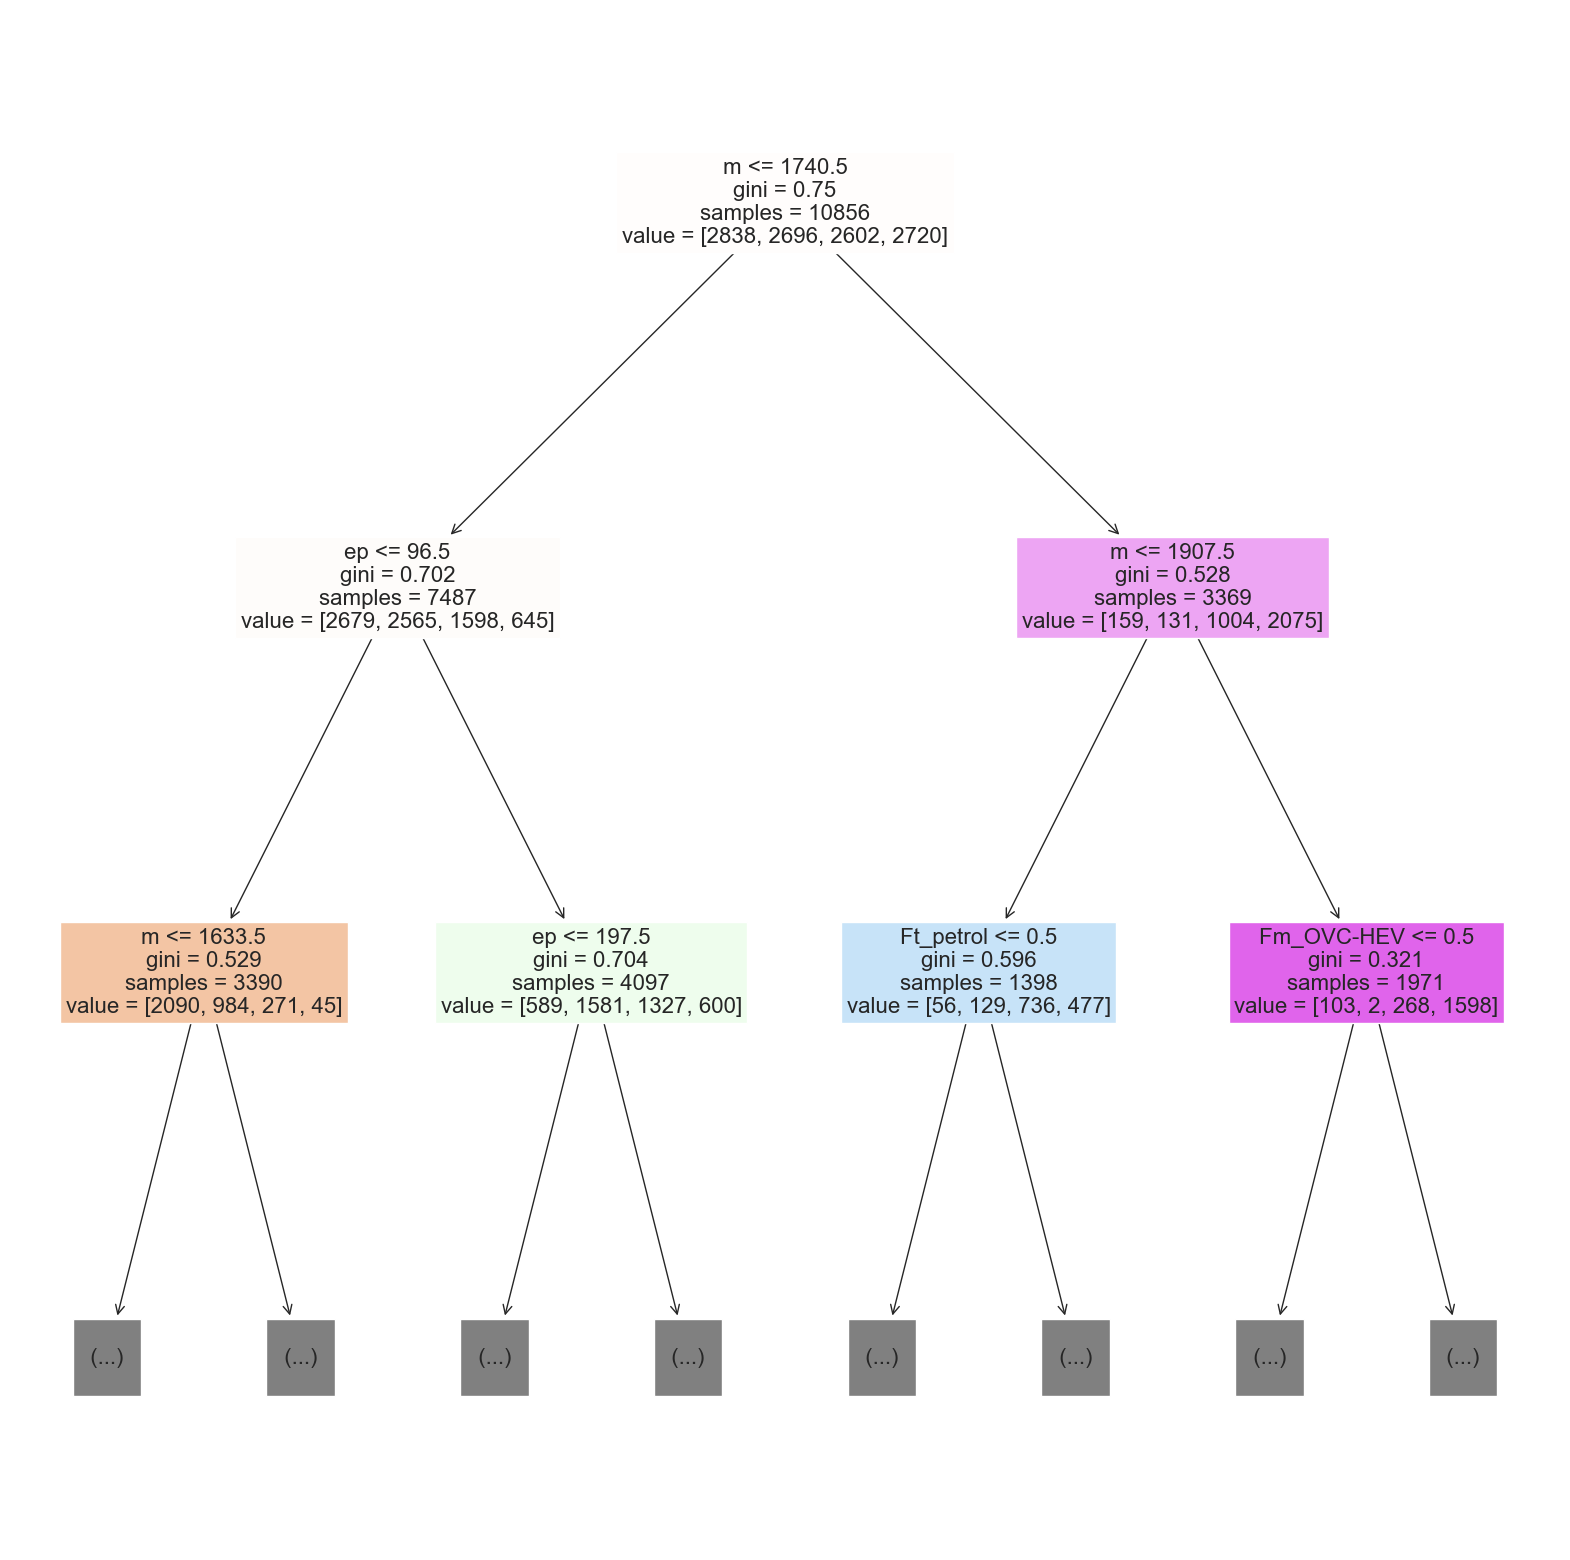

In [560]:
# Visualisation de l'arbre de décision avec critère gini
plt.figure(figsize=(20,20))
plot_tree(dt, max_depth=2, feature_names=features_nedc.columns, filled=True, fontsize=16);

### Norme WLTP

#### Entrainement d'un modèle par défaut et affichage de ses performances

In [568]:
# Entrainement d'un premier modèle d'arbres de décision (WLTP)
dt = DecisionTreeClassifier()
dt.fit(X_train_wltp, y_train_wltp)
# Affichage des performances du modèle
y_pred_train = dt.predict(X_train_wltp)
y_pred_test = dt.predict(X_test_wltp)
print(classification_report(y_train_wltp, y_pred_train))
print(classification_report(y_test_wltp, y_pred_test))
pd.crosstab(y_test_wltp, y_pred_test, colnames=['Predictions'])

              precision    recall  f1-score   support

           1       0.98      1.00      0.99      2858
           2       0.98      0.98      0.98      2623
           3       0.99      0.98      0.99      2764
           4       1.00      0.99      1.00      2611

    accuracy                           0.99     10856
   macro avg       0.99      0.99      0.99     10856
weighted avg       0.99      0.99      0.99     10856

              precision    recall  f1-score   support

           1       0.84      0.89      0.87       645
           2       0.76      0.74      0.75       685
           3       0.81      0.79      0.80       700
           4       0.92      0.92      0.92       685

    accuracy                           0.83      2715
   macro avg       0.83      0.84      0.84      2715
weighted avg       0.83      0.83      0.83      2715



Predictions,1,2,3,4
EwltpQuart,,,,
1,574,68,3,0
2,99,510,76,0
3,7,90,551,52
4,0,1,52,632


#### Optimisation du modèle par méthode GridSearchCV

In [567]:
# Optimisation du modèle par méthode GridSearchCV (WLTP)
param_grid = {
    "max_depth": [3,5,10,15,20,30,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

grid_cv = GridSearchCV(dt, param_grid, n_jobs=-1, cv=3).fit(X_train_wltp, y_train_wltp)

print("Meilleurs paramètres par GS :", grid_cv.best_params_)
print("CV score par GS :", grid_cv.best_score_)

# Affichage des performances du modèle
y_pred_train = grid_cv.predict(X_train_wltp)
y_pred_test = grid_cv.predict(X_test_wltp)
print('\n', classification_report(y_train_wltp, y_pred_train))
print(classification_report(y_test_wltp, y_pred_test))
pd.crosstab(y_test_wltp, y_pred_test, colnames=['Predictions'])

Meilleurs paramètres par GS : {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score par GS : 0.8287582534962655

               precision    recall  f1-score   support

           1       0.93      0.95      0.94      2858
           2       0.87      0.88      0.88      2623
           3       0.94      0.92      0.93      2764
           4       1.00      0.98      0.99      2611

    accuracy                           0.93     10856
   macro avg       0.93      0.93      0.93     10856
weighted avg       0.93      0.93      0.93     10856

              precision    recall  f1-score   support

           1       0.86      0.89      0.88       645
           2       0.76      0.77      0.77       685
           3       0.82      0.79      0.80       700
           4       0.93      0.93      0.93       685

    accuracy                           0.84      2715
   macro avg       0.84      0.84      0.84      2715
weighted avg       0.84      0.84      0.84      27

Predictions,1,2,3,4
EwltpQuart,,,,
1,575,68,2,0
2,85,526,74,0
3,7,93,550,50
4,0,1,47,637


#### Affichage des variables les plus importantes

In [569]:
feats = {}
for feature, importance in zip(features_wltp.columns, dt.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient = 'index').rename(columns = {0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
Mt,0.479202
ep,0.109180
W,0.091615
At1,0.080541
ec,0.047738
Ft_petrol,0.041188
Fm_OVC-HEV,0.029707
Mp_TOYOTA-MAZDA,0.014341


#### Visualisation des premières branches de l'arbre de décisions

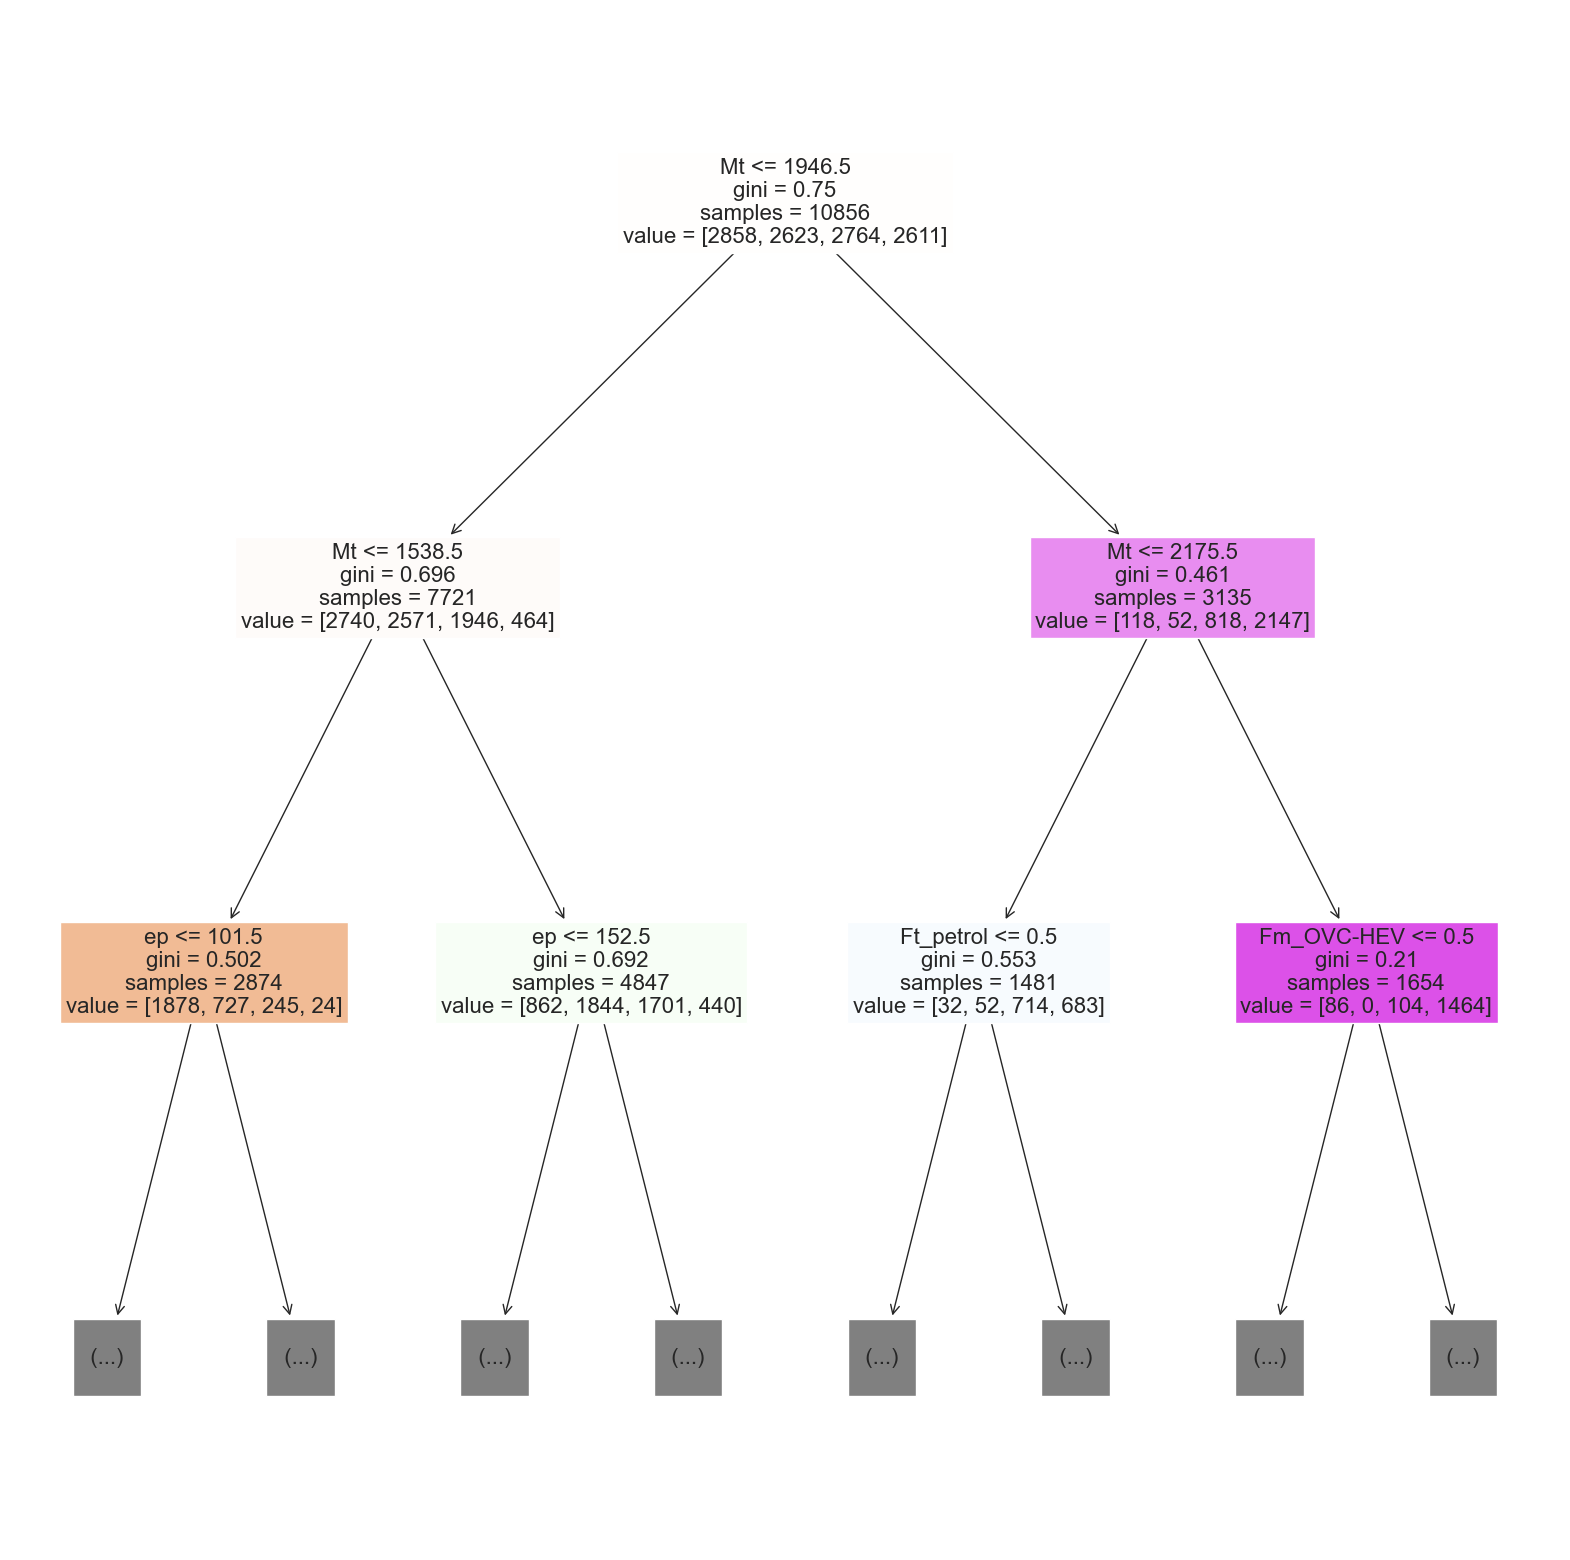

In [570]:
# Visualisation de l'arbre de décision avec critère gini
plt.figure(figsize=(20,20))
plot_tree(dt, max_depth=2, feature_names=features_wltp.columns, filled=True, fontsize=16);

## <a name="xgboost"></a>  4ème modèle : XGBoost

### Norme NEDC

#### Préparation des matrices d'entrainement et de test

In [571]:
# Préparation des données pour XGBoost (NEDC)
train_nedc = xgb.DMatrix(X_train_nedc, y_train_nedc)
test_nedc = xgb.DMatrix(X_test_nedc, y_test_nedc)

#### Entrainement d'un modèle XGBoost simple et affichage de ses performances

In [572]:
# Sélection des paramètres
params = {'eval_metric': 'mlogloss', 'max_depth': 8, 'learning_rate': 0.1, 'subsample' :0.5,
                         'objective': 'multi:softmax', 'num_class': 5}
# Entrainement du modèle XGBoost (NEDC)
xgb1 = xgb.train(params = params, dtrain = train_nedc, num_boost_round = 200, early_stopping_rounds= 15,
                 evals= [(train_nedc, 'train'), (test_nedc, 'eval')])

# Affichage des performances du modèle (NEDC)
y_pred_train_nedc = xgb1.predict(train_nedc)
y_pred_test_nedc = xgb1.predict(test_nedc)
print(classification_report(y_train_nedc, y_pred_train_nedc))
print(classification_report(y_test_nedc, y_pred_test_nedc))
pd.crosstab(y_test_nedc, y_pred_test_nedc, colnames=['Predictions'])

[0]	train-mlogloss:1.46621	eval-mlogloss:1.46975
[1]	train-mlogloss:1.34554	eval-mlogloss:1.35268
[2]	train-mlogloss:1.24715	eval-mlogloss:1.25846
[3]	train-mlogloss:1.15649	eval-mlogloss:1.17124
[4]	train-mlogloss:1.08265	eval-mlogloss:1.10004
[5]	train-mlogloss:1.01632	eval-mlogloss:1.03434
[6]	train-mlogloss:0.95644	eval-mlogloss:0.97668
[7]	train-mlogloss:0.90109	eval-mlogloss:0.92302
[8]	train-mlogloss:0.85347	eval-mlogloss:0.87702
[9]	train-mlogloss:0.80942	eval-mlogloss:0.83518
[10]	train-mlogloss:0.77155	eval-mlogloss:0.79884
[11]	train-mlogloss:0.73694	eval-mlogloss:0.76597
[12]	train-mlogloss:0.70351	eval-mlogloss:0.73364
[13]	train-mlogloss:0.67390	eval-mlogloss:0.70548
[14]	train-mlogloss:0.64671	eval-mlogloss:0.67919
[15]	train-mlogloss:0.62117	eval-mlogloss:0.65454
[16]	train-mlogloss:0.59818	eval-mlogloss:0.63272
[17]	train-mlogloss:0.57715	eval-mlogloss:0.61323
[18]	train-mlogloss:0.55644	eval-mlogloss:0.59378
[19]	train-mlogloss:0.53846	eval-mlogloss:0.57644
[20]	train

[163]	train-mlogloss:0.15942	eval-mlogloss:0.25881
[164]	train-mlogloss:0.15892	eval-mlogloss:0.25827
[165]	train-mlogloss:0.15846	eval-mlogloss:0.25812
[166]	train-mlogloss:0.15810	eval-mlogloss:0.25805
[167]	train-mlogloss:0.15768	eval-mlogloss:0.25764
[168]	train-mlogloss:0.15733	eval-mlogloss:0.25758
[169]	train-mlogloss:0.15676	eval-mlogloss:0.25755
[170]	train-mlogloss:0.15635	eval-mlogloss:0.25719
[171]	train-mlogloss:0.15591	eval-mlogloss:0.25675
[172]	train-mlogloss:0.15561	eval-mlogloss:0.25655
[173]	train-mlogloss:0.15529	eval-mlogloss:0.25649
[174]	train-mlogloss:0.15503	eval-mlogloss:0.25641
[175]	train-mlogloss:0.15468	eval-mlogloss:0.25599
[176]	train-mlogloss:0.15434	eval-mlogloss:0.25582
[177]	train-mlogloss:0.15392	eval-mlogloss:0.25542
[178]	train-mlogloss:0.15346	eval-mlogloss:0.25540
[179]	train-mlogloss:0.15310	eval-mlogloss:0.25534
[180]	train-mlogloss:0.15281	eval-mlogloss:0.25541
[181]	train-mlogloss:0.15245	eval-mlogloss:0.25575
[182]	train-mlogloss:0.15220	ev

Predictions,1.0,2.0,3.0,4.0
EnedcQuart,,,,
1,659,61,0,0
2,54,552,46,0
3,1,53,633,22
4,0,1,38,595


#### Optimisation des hyperparamètres XGBoost à l'aide de la librairie HYPEROPT

In [575]:
# Instanciaition du cross validateur
kfold = KFold(n_splits=3, shuffle=True, random_state=0)

In [576]:
def objective(space):

    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = xgb.XGBClassifier(max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree'],
                            eval_metric = 'mlogloss', 
                            objective = 'multi:softmax',
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'])
    
    classifier.fit(X_train_nedc, y_train_nedc)

    # K-Fold Cross Validation
    accuracies = cross_val_score(estimator = classifier, X = X_train_nedc, y = y_train_nedc, cv = 3)
    CrossValMean = accuracies.mean()

    print("CrossValMean:", CrossValMean)

    return{'loss':1-CrossValMean, 'status': STATUS_OK }

# Initialisation de l'espace de paramètres (étendue des valeurs)
space = {
    'max_depth' : hp.choice('max_depth', range(2, 16, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.1, 1, 0.1),
    'gamma' : hp.quniform('gamma', 0, 0.3, 0.02),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.1),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.1),
    'reg_alpha' : hp.quniform('reg_alpha', 0, 1, 0.05), 
    'reg_lambda' : hp.quniform('reg_lambda', 0, 2.5, 0.1)}


In [577]:
# Recherche des meilleurs paramètres
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Meilleurs paramètres: ", best)


CrossValMean:                                         
0.8829214178002154                                    
CrossValMean:                                                                    
0.881631978064708                                                                
CrossValMean:                                                                    
0.874354675508481                                                                
CrossValMean:                                                                    
0.8072029962047957                                                               
CrossValMean:                                                                    
0.837416796768972                                                                
CrossValMean:                                                                    
0.8691042500188261                                                               
CrossValMean:                                                         

0.8361268733344525                                                                
100%|██████████| 50/50 [03:15<00:00,  3.91s/trial, best loss: 0.10961714306691539]
Meilleurs paramètres:  {'colsample_bytree': 0.7000000000000001, 'gamma': 0.1, 'learning_rate': 0.4, 'max_depth': 10, 'min_child_weight': 3.0, 'reg_alpha': 0.1, 'reg_lambda': 0.0, 'subsample': 0.8}


In [578]:
params = {'objective': 'multi:softmax', 'eval_metric' : 'mlogloss', 'num_class': 5}

# Ajout des meilleurs paramètres sélectionnés au dictionnaire "params"
params.update(best)

# Entrainement du modèle XGBoost optimisé (NEDC)
xgb2 = xgb.train(params = params, dtrain = train_nedc, num_boost_round = 600, early_stopping_rounds= 15,
                 evals= [(train_nedc, 'train'), (test_nedc, 'eval')])

# Affichage des performances du modèle optimisé (NEDC)
y_pred_train_nedc = xgb2.predict(train_nedc)
y_pred_test_nedc = xgb2.predict(test_nedc)
print(classification_report(y_train_nedc, y_pred_train_nedc))
print(classification_report(y_test_nedc, y_pred_test_nedc))
pd.crosstab(y_test_nedc, y_pred_test_nedc, colnames=['Predictions'])

[0]	train-mlogloss:1.12775	eval-mlogloss:1.14953
[1]	train-mlogloss:0.84123	eval-mlogloss:0.87579
[2]	train-mlogloss:0.68745	eval-mlogloss:0.73061
[3]	train-mlogloss:0.57471	eval-mlogloss:0.61990
[4]	train-mlogloss:0.48726	eval-mlogloss:0.53630
[5]	train-mlogloss:0.42756	eval-mlogloss:0.47763
[6]	train-mlogloss:0.37856	eval-mlogloss:0.43351
[7]	train-mlogloss:0.34457	eval-mlogloss:0.40223
[8]	train-mlogloss:0.31689	eval-mlogloss:0.37935
[9]	train-mlogloss:0.29520	eval-mlogloss:0.36053
[10]	train-mlogloss:0.27419	eval-mlogloss:0.34119
[11]	train-mlogloss:0.25901	eval-mlogloss:0.32769
[12]	train-mlogloss:0.24679	eval-mlogloss:0.31698
[13]	train-mlogloss:0.23710	eval-mlogloss:0.30872
[14]	train-mlogloss:0.22879	eval-mlogloss:0.30197
[15]	train-mlogloss:0.22167	eval-mlogloss:0.29747
[16]	train-mlogloss:0.21354	eval-mlogloss:0.29079
[17]	train-mlogloss:0.20835	eval-mlogloss:0.28627
[18]	train-mlogloss:0.20239	eval-mlogloss:0.28184
[19]	train-mlogloss:0.19805	eval-mlogloss:0.27799
[20]	train

Predictions,1.0,2.0,3.0,4.0
EnedcQuart,,,,
1,667,53,0,0
2,57,550,45,0
3,1,41,644,23
4,0,1,34,599


#### Affichage de l'importance des variables

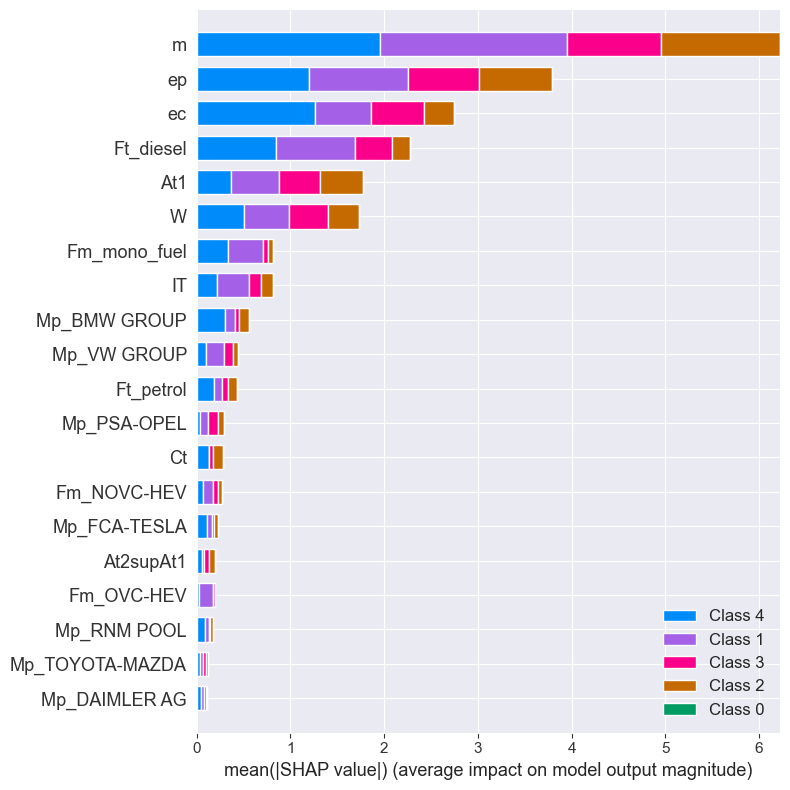

In [579]:
# Valeurs de Shapley
explainer = shap.TreeExplainer(xgb2)
shap_values = explainer.shap_values(X_test_nedc)

plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
shap.summary_plot(shap_values, X_test_nedc, plot_type="bar", plot_size=None, show=True)

### Norme WLTP

#### Préparation des matrices d'entrainement et de test

In [580]:
# Préparation des données pour XGBoost (WLTP)
train_wltp = xgb.DMatrix(X_train_wltp, y_train_wltp)
test_wltp = xgb.DMatrix(X_test_wltp, y_test_wltp)

#### Entrainement d'un modèle XGBoost simple et affichage de ses performances

In [581]:
# Sélection des paramètres
params = {'eval_metric': 'mlogloss', 'max_depth': 8, 'learning_rate': 0.1, 'subsample' :0.5,
                         'objective': 'multi:softmax', 'num_class': 5}
# Entrainement du modèle XGBoost (WLTP)
xgb3 = xgb.train(params = params, dtrain = train_wltp, num_boost_round = 200, early_stopping_rounds= 15,
                 evals= [(train_wltp, 'train'), (test_wltp, 'eval')])

# Affichage des performances du modèle (WLTP)
y_pred_train = xgb3.predict(train_wltp)
y_pred_test = xgb3.predict(test_wltp)
print(classification_report(y_train_wltp, y_pred_train))
print(classification_report(y_test_wltp, y_pred_test))
pd.crosstab(y_test_wltp, y_pred_test, colnames=['Predictions'])

[0]	train-mlogloss:1.46281	eval-mlogloss:1.46852
[1]	train-mlogloss:1.34124	eval-mlogloss:1.35017
[2]	train-mlogloss:1.24048	eval-mlogloss:1.25382
[3]	train-mlogloss:1.15419	eval-mlogloss:1.17127
[4]	train-mlogloss:1.07710	eval-mlogloss:1.09648
[5]	train-mlogloss:1.00937	eval-mlogloss:1.03201
[6]	train-mlogloss:0.95074	eval-mlogloss:0.97481
[7]	train-mlogloss:0.89773	eval-mlogloss:0.92357
[8]	train-mlogloss:0.85003	eval-mlogloss:0.87764
[9]	train-mlogloss:0.80852	eval-mlogloss:0.83785
[10]	train-mlogloss:0.76927	eval-mlogloss:0.80022
[11]	train-mlogloss:0.73415	eval-mlogloss:0.76583
[12]	train-mlogloss:0.70164	eval-mlogloss:0.73484
[13]	train-mlogloss:0.67218	eval-mlogloss:0.70677
[14]	train-mlogloss:0.64572	eval-mlogloss:0.68117
[15]	train-mlogloss:0.61954	eval-mlogloss:0.65690
[16]	train-mlogloss:0.59647	eval-mlogloss:0.63540
[17]	train-mlogloss:0.57546	eval-mlogloss:0.61560
[18]	train-mlogloss:0.55646	eval-mlogloss:0.59816
[19]	train-mlogloss:0.53846	eval-mlogloss:0.58116
[20]	train

[163]	train-mlogloss:0.14889	eval-mlogloss:0.30287
[164]	train-mlogloss:0.14827	eval-mlogloss:0.30247
[165]	train-mlogloss:0.14757	eval-mlogloss:0.30238
[166]	train-mlogloss:0.14692	eval-mlogloss:0.30236
[167]	train-mlogloss:0.14629	eval-mlogloss:0.30207
[168]	train-mlogloss:0.14576	eval-mlogloss:0.30212
[169]	train-mlogloss:0.14537	eval-mlogloss:0.30182
[170]	train-mlogloss:0.14489	eval-mlogloss:0.30193
[171]	train-mlogloss:0.14424	eval-mlogloss:0.30207
              precision    recall  f1-score   support

           1       0.96      0.96      0.96      2858
           2       0.92      0.92      0.92      2623
           3       0.95      0.94      0.95      2764
           4       0.99      0.99      0.99      2611

    accuracy                           0.95     10856
   macro avg       0.95      0.95      0.95     10856
weighted avg       0.95      0.95      0.95     10856

              precision    recall  f1-score   support

           1       0.88      0.90      0.89       6

Predictions,1.0,2.0,3.0,4.0
EwltpQuart,,,,
1,583,60,2,0
2,80,543,62,0
3,1,68,594,37
4,0,0,36,649


#### Optimisation des hyperparamètres XGBoost à l'aide de la librairie HYPEROPT

In [582]:
# Instanciaition du cross validateur
kfold = KFold(n_splits=3, shuffle=True, random_state=0)

In [583]:
def objective(space):

    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = xgb.XGBClassifier(max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree'],
                            eval_metric = 'mlogloss', 
                            objective = 'multi:softmax',
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'])
    
    classifier.fit(X_train_wltp, y_train_wltp)

    # K-Fold Cross Validation
    accuracies = cross_val_score(estimator = classifier, X = X_train_wltp, y = y_train_wltp, cv = 3)
    CrossValMean = accuracies.mean()

    print("CrossValMean:", CrossValMean)

    return{'loss':1-CrossValMean, 'status': STATUS_OK }

# Initialisation de l'espace de paramètres (étendue des valeurs)
space = {
    'max_depth' : hp.choice('max_depth', range(2, 16, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.1, 1, 0.1),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.1),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.1),
    'reg_alpha' : hp.quniform('reg_alpha', 0, 1, 0.05), 
    'reg_lambda' : hp.quniform('reg_lambda', 0, 2.5, 0.1)}


In [584]:
# Recherche des meilleurs paramètres
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Meilleurs paramètres: ", best)


CrossValMean:                                         
0.851694929709114                                     
CrossValMean:                                                                    
0.8583270286985751                                                               
CrossValMean:                                                                    
0.8629330652724323                                                               
CrossValMean:                                                                    
0.8438650646759042                                                              
CrossValMean:                                                                   
0.8631174564275019                                                              
CrossValMean:                                                                    
0.8391676089887161                                                               
CrossValMean:                                                            

0.8522474158125687                                                                
100%|██████████| 50/50 [03:20<00:00,  4.00s/trial, best loss: 0.13476414556122407]
Meilleurs paramètres:  {'colsample_bytree': 1.0, 'gamma': 0.19, 'learning_rate': 0.2, 'max_depth': 13, 'min_child_weight': 5.0, 'reg_alpha': 1.0, 'reg_lambda': 2.3000000000000003, 'subsample': 0.9}


In [585]:
params = {'objective': 'multi:softmax', 'eval_metric' : 'mlogloss', 'num_class': 5}

# Ajout des meilleurs paramètres sélectionnés au dictionnaire "params"
params.update(best)

# Entrainement du modèle XGBoost optimisé (WLTP)
xgb4 = xgb.train(params = params, dtrain = train_wltp, num_boost_round = 600, early_stopping_rounds= 15,
                 evals= [(train_wltp, 'train'), (test_wltp, 'eval')])

# Affichage des performances du modèle optimisé (WLTP)
y_pred_train_wltp = xgb4.predict(train_wltp)
y_pred_test_wltp = xgb4.predict(test_wltp)
print(classification_report(y_train_wltp, y_pred_train_wltp))
print(classification_report(y_test_wltp, y_pred_test_wltp))
pd.crosstab(y_test_wltp, y_pred_test_wltp, colnames=['Predictions'])

[0]	train-mlogloss:1.31271	eval-mlogloss:1.32684
[1]	train-mlogloss:1.11339	eval-mlogloss:1.13545
[2]	train-mlogloss:0.96468	eval-mlogloss:0.99331
[3]	train-mlogloss:0.84529	eval-mlogloss:0.87894
[4]	train-mlogloss:0.75315	eval-mlogloss:0.79019
[5]	train-mlogloss:0.67922	eval-mlogloss:0.71950
[6]	train-mlogloss:0.61779	eval-mlogloss:0.66188
[7]	train-mlogloss:0.56513	eval-mlogloss:0.61295
[8]	train-mlogloss:0.52243	eval-mlogloss:0.57302
[9]	train-mlogloss:0.48579	eval-mlogloss:0.53921
[10]	train-mlogloss:0.45543	eval-mlogloss:0.51027
[11]	train-mlogloss:0.42990	eval-mlogloss:0.48769
[12]	train-mlogloss:0.40643	eval-mlogloss:0.46628
[13]	train-mlogloss:0.38769	eval-mlogloss:0.44931
[14]	train-mlogloss:0.36935	eval-mlogloss:0.43277
[15]	train-mlogloss:0.35460	eval-mlogloss:0.41950
[16]	train-mlogloss:0.34010	eval-mlogloss:0.40684
[17]	train-mlogloss:0.32830	eval-mlogloss:0.39716
[18]	train-mlogloss:0.31803	eval-mlogloss:0.38880
[19]	train-mlogloss:0.30951	eval-mlogloss:0.38146
[20]	train

Predictions,1.0,2.0,3.0,4.0
EwltpQuart,,,,
1,584,58,3,0
2,79,544,62,0
3,1,64,598,37
4,0,0,31,654


#### Affichage de l'importance des variables

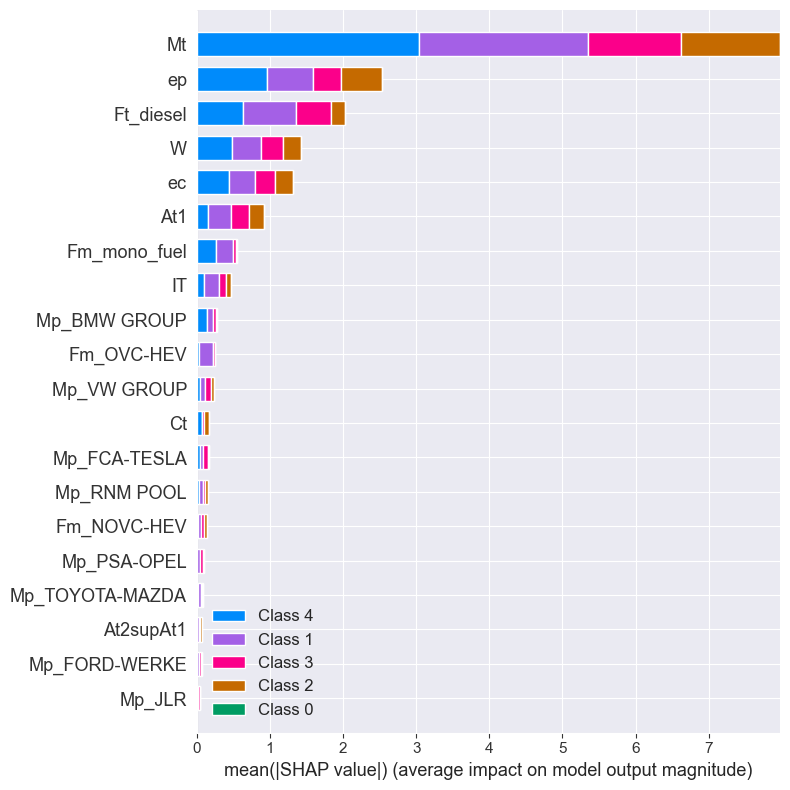

In [586]:
# Valeurs de Shapley
explainer = shap.TreeExplainer(xgb4)
shap_values = explainer.shap_values(X_test_wltp)

plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
shap.summary_plot(shap_values, X_test_wltp, plot_type="bar", plot_size=None, show=True)

## Bonus : Algorithmes abandonnés dans la version finale du rapport

### Boosting : Adaboost

In [ ]:
'''Entrainement de l'algorithme de Boosting : AdaBoost (NEDC)
ac = AdaBoostClassifier(base_estimator=dt, n_estimators=100)
ac.fit(X_train_nedc, y_train_nedc)
# Affichage des performances du modèle
y_pred_train = ac.predict(X_train_nedc)
y_pred_test = ac.predict(X_test_nedc)
print(classification_report(y_train_nedc, y_pred_train))
print(classification_report(y_test_nedc, y_pred_test))
print(ac.score(X_test_nedc, y_test_nedc))
pd.crosstab(y_test_nedc, y_pred_test, colnames=['Predictions'])
'''

In [ ]:
'''Entrainement de l'algorithme de Boosting : AdaBoost
ac = AdaBoostClassifier(base_estimator=dt, n_estimators=100)
ac.fit(X_train_wltp, y_train_wltp)
# Affichage des performances du modèle
y_pred_train = ac.predict(X_train_wltp)
y_pred_test = ac.predict(X_test_wltp)
print(classification_report(y_train_wltp, y_pred_train))
print(classification_report(y_test_wltp, y_pred_test))
print(ac.score(X_test_wltp, y_test_wltp))
pd.crosstab(y_test_wltp, y_pred_test, colnames=['Predictions'])
'''

### Bagging Classifier

In [ ]:
'''Entrainement de l'algorithme de Bootsrap Aggregating : BaggingClassifier (NEDC)
bc = BaggingClassifier(base_estimator=dt, n_estimators=100)
bc.fit(X_train_nedc, y_train_nedc)
# Affichage des performances du modèle
y_pred_train = bc.predict(X_train_nedc)
y_pred_test = bc.predict(X_test_nedc)
print(classification_report(y_train_nedc, y_pred_train))
print(classification_report(y_test_nedc, y_pred_test))
print(ac.score(X_test_nedc, y_test_nedc))
pd.crosstab(y_test_nedc, y_pred_test, colnames=['Predictions'])
'''

In [ ]:
'''Entrainement de l'algorithme de Bootsrap Aggregating : BaggingClassifier (WLTP)
bc = BaggingClassifier(base_estimator=dt, n_estimators=100)
bc.fit(X_train_wltp, y_train_wltp)
# Affichage des performances du modèle
y_pred_train = bc.predict(X_train_wltp)
y_pred_test = bc.predict(X_test_wltp)
print(classification_report(y_train_wltp, y_pred_train))
print(classification_report(y_test_wltp, y_pred_test))
print(ac.score(X_test_wltp, y_test_wltp))
pd.crosstab(y_test_wltp, y_pred_test, colnames=['Predictions'])
'''

### Forêts aléatoires

In [ ]:
'''Entrainement de l'algorithme des forêts aléatoires (NEDC)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_nedc, y_train_nedc)
# Affichage des performances du modèle
y_pred_train = rf.predict(X_train_nedc)
y_pred_test = rf.predict(X_test_nedc)
print(classification_report(y_train_nedc, y_pred_train))
print(classification_report(y_test_nedc, y_pred_test))
print(ac.score(X_test_nedc, y_test_nedc))
pd.crosstab(y_test_nedc, y_pred_test, colnames=['Predictions'])
'''

In [ ]:
'''Optimisation du modèle Random Forest par méthode GridSearchCV (NEDC)
param_grid = {
    "max_depth": [10,15,20,30],
    "min_samples_split": [2,3,5,7],
    "min_samples_leaf": [1,2,5],
    "n_estimators": [100,200,300]
}

grid_cv = GridSearchCV(rf, param_grid, n_jobs=-1, cv=3).fit(X_train_nedc, y_train_nedc)

print("Meilleurs paramètres par GS :", grid_cv.best_params_)
print("CV score par GS :", grid_cv.best_score_)

# Affichage des performances du modèle
y_pred_train = grid_cv.predict(X_train_nedc)
y_pred_test = grid_cv.predict(X_test_nedc)
print('\n', classification_report(y_train_nedc, y_pred_train))
print(classification_report(y_test_nedc, y_pred_test))
pd.crosstab(y_test_nedc, y_pred_test, colnames=['Predictions'])
'''

In [ ]:
'''Entrainement de l'algorithme des forêts aléatoires (WLTP)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_wltp, y_train_wltp)
# Affichage des performances du modèle
y_pred_train = rf.predict(X_train_wltp)
y_pred_test = rf.predict(X_test_wltp)
print(classification_report(y_train_wltp, y_pred_train))
print(classification_report(y_test_wltp, y_pred_test))
print(ac.score(X_test_wltp, y_test_wltp))
pd.crosstab(y_test_wltp, y_pred_test, colnames=['Predictions'])
'''

In [ ]:
'''Optimisation du modèle Random Forest par méthode GridSearchCV (WLTP)
param_grid = {
    "max_depth": [10,15,20,30],
    "min_samples_split": [2,3,5,7],
    "min_samples_leaf": [1,2,5],
    "n_estimators": [100,200,300]
}

grid_cv = GridSearchCV(rf, param_grid, n_jobs=-1, cv=3).fit(X_train_wltp, y_train_wltp)

print("Meilleurs paramètres par GS :", grid_cv.best_params_)
print("CV score par GS :", grid_cv.best_score_)

# Affichage des performances du modèle
y_pred_train = grid_cv.predict(X_train_wltp)
y_pred_test = grid_cv.predict(X_test_wltp)
print('\n', classification_report(y_train_wltp, y_pred_train))
print(classification_report(y_test_wltp, y_pred_test))
pd.crosstab(y_test_wltp, y_pred_test, colnames=['Predictions'])
'''